##Introduction to Quanvolutional Neural Networks
Convolutional Neural Network (CNN)
CNNs are a staple in the analysis of visual imagery, utilizing convolutional layers to apply filters to input images, thereby generating feature maps for classification or other tasks. These networks excel in capturing spatial hierarchies in images through the application of the Frobenius inner product and subsequent activation functions.

Quantum Convolution (Quanvolution)
Extending the principles of classical convolution, quanvolution involves replacing classical convolution filters with variational quantum circuits, thereby creating QNNs. These quantum-based filters can perform complex operations in a higher-dimensional Hilbert space, potentially offering advantages over traditional methods by leveraging quantum mechanics' unique properties.

#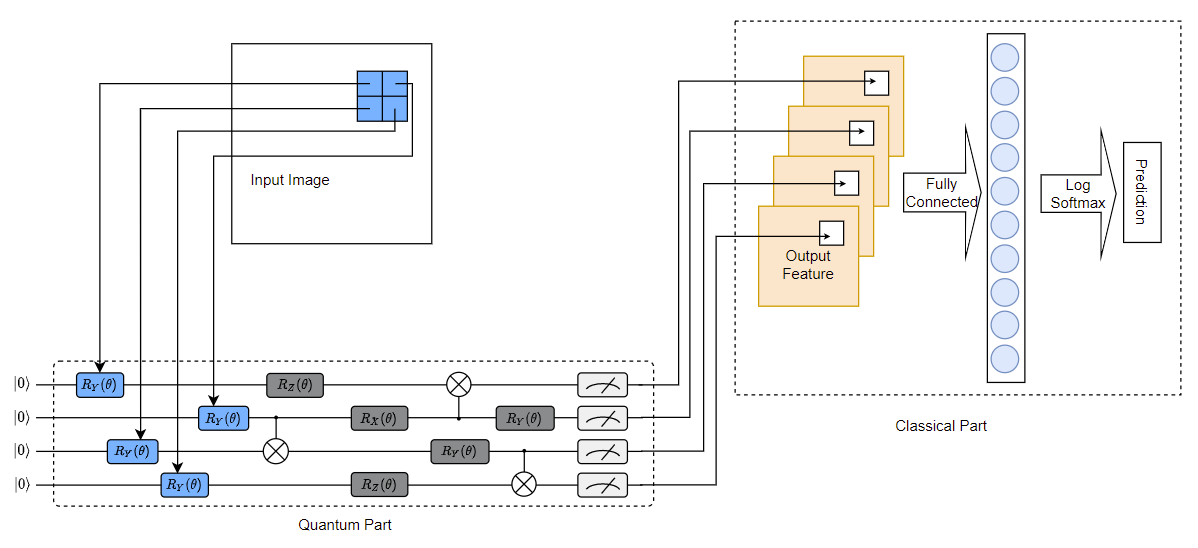 Quanvolution (Quantum convolution) for MNIST image classification with TorchQuantum


##Build and train a Quanvolutional Neural Network.

###Installation
The setup process involves installing the TorchQuantum library, setting up the environment, and preparing necessary Python packages for running the tutorial. This includes setting up Qiskit for quantum computing simulation and configuring access to IBM Quantum services for executing quantum circuits on real quantum hardware

In [ ]:
!pip install qiskit==0.32.1

     |████████████████████████████████| 6.1 MB 4.1 MB/s 
     |████████████████████████████████| 17.9 MB 633 kB/s 
     |████████████████████████████████| 237 kB 73.3 MB/s 
     |████████████████████████████████| 207 kB 65.4 MB/s 
     |████████████████████████████████| 2.1 MB 60.5 MB/s 
     |████████████████████████████████| 634 kB 68.2 MB/s 
     |████████████████████████████████| 1.6 MB 21.6 MB/s 
     |████████████████████████████████| 53 kB 2.7 MB/s 
     |████████████████████████████████| 38.2 MB 116 kB/s 
     |████████████████████████████████| 943 kB 22.1 MB/s 
     |████████████████████████████████| 49 kB 8.3 MB/s 
     |████████████████████████████████| 3.6 MB 31.3 MB/s 
     |████████████████████████████████| 63 kB 814 kB/s 
     |████████████████████████████████| 6.4 MB 30.3 MB/s 
  Created wheel for qiskit: filename=qiskit-0.32.1-py3-none-any.whl size=11777 sha256=911365fec91e5c648d2569b156af429c0aff7c3d95d453a7d24e6bf8d7d1a315
  Stored in directory: /root/.cache/pip/whee

Download and cd to the repo.

In [ ]:
!git clone https://github.com/mit-han-lab/torchquantum.git

Cloning into 'torchquantum'...
remote: Enumerating objects: 10737, done.
remote: Counting objects: 100% (7529/7529), done.
remote: Compressing objects: 100% (3777/3777), done.
remote: Total 10737 (delta 3765), reused 7076 (delta 3348), pack-reused 3208
Receiving objects: 100% (10737/10737), 3.19 MiB | 12.92 MiB/s, done.
Resolving deltas: 100% (5732/5732), done.
Checking out files: 100% (50055/50055), done.


In [ ]:
%cd torchquantum

/content/torchquantum


Install torch-quantum.

In [ ]:
!pip install --editable .

Obtaining file:///content/torchquantum
     |████████████████████████████████| 11.2 MB 6.5 MB/s 
     |████████████████████████████████| 81 kB 12.1 MB/s 
     |████████████████████████████████| 895 kB 55.2 MB/s 
     |████████████████████████████████| 65 kB 4.1 MB/s 
     |████████████████████████████████| 296 kB 57.1 MB/s 
     |████████████████████████████████| 58 kB 2.6 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
  Running setup.py develop for torchquantum
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Change PYTHONPATH and install other packages.

In [ ]:
%env PYTHONPATH=.

env: PYTHONPATH=.


Run the following code to store a qiskit token. You can replace it with your own token from your IBMQ account if you like.



In [ ]:
from qiskit import IBMQ
IBMQ.save_account('0238b0afc0dc515fe7987b02706791d1719cb89b68befedc125eded0607e6e9e9f26d3eed482f66fdc45fdfceca3aab2edb9519d96b39e9c78040194b86e7858', overwrite=True)

In [ ]:
!pip install matplotlib==3.1.3

     |████████████████████████████████| 13.1 MB 4.3 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchquantum 0.1.0 requires matplotlib>=3.3.2, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!ls artifact

aerbackend.py  example2  example4  example6  README.md
example1       example3  example5  example7


In [ ]:
!cp artifact/aerbackend.py ../../usr/local/lib/python3.7/dist-packages/qiskit/providers/aer/backends/ -r

### Step
Our code requires torchquantum lib, mnist dataset, pytorch and numpy. We need torch and the logsoftmax function from `torch.nn.functional`, optimizers(`optim`), `torchquantum` module, MNIST dataset(`MNIST`), cosine annealing learning rate(`CosineAnnealingLR`).


In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import torchquantum as tq
import random

from torchquantum.datasets import MNIST
from torch.optim.lr_scheduler import CosineAnnealingLR

### Build a quanvolutional filter
Our quanvolution model is a hybrid model. It consists of two parts, the quanvolutional filter part and the classical layer part. To build the model, firstly we define our quanvolutional filter. Our quanvolutional filter’s structure is the same as the figure described above. It has four qubits. The `tq.QuantumDevice` module stores the state vector. Usually a Quantum Neural Network module consists of three parts: encoder, ansatz and measurement. We can create an encoder by passing a list of gates to `tq.GeneralEncoder`. Each entry in the list contains `input_idx`, `func`, and `wires`. Here, each qubit has a rotation-Y gate. 4 RY gates in total. They can encode the 2x2 input data to the quantum state. Then we decide our ansatz to be a random layer. We call `tq.RandomLayer` to create an ansatz composed by 8 basic gates with no more than 8 trainable parameters. And finally we perform Pauli-Z measurements on each qubit by creating a `tq.MeasureAll` module and passing `tq.PauliZ` to it. The measure function will return four expectation values from four qubits. The four results go to four channels.

Next look at how quanvolutional filter works. We get the batch size. Our image is 28x28. So we reshape our input data to `(bsz, 28, 28)`.

We initialize the `data_list`. The list stores the outputs in each stride. The double loop is to iterate all the possible positions that the quanvolutional filter window may stride in. Here the stride is 2. Then we catenate the data in the 2x2 window. Here we catenate four lists to one big list, so we need to reshape the list to `(4, bsz)` and transpose it to `(bsz, 4)`.

Next if you want to use qiskit’s remote noise model or real quantum machine, you can set `use_qiskit=True` and pass these 5 parameters: `q_device`, `encoder`, `q_layer`, `measure`, and `data`. The `qiskit_processor` will receive these parameters, put the data in the encoder, run the while circuits and return the measurement result. Remember only when the model is doing an inference can you use qiskit remote. After each stride, we append the measurement result to `data_list`. Finally, we catenate the `data_list` along dimension 1 and return the result.


In [ ]:
class QuanvolutionFilter(tq.QuantumModule):
    def __init__(self):
        super().__init__()
        self.n_wires = 4
        self.q_device = tq.QuantumDevice(n_wires=self.n_wires)
        self.encoder = tq.GeneralEncoder(
        [   {'input_idx': [0], 'func': 'ry', 'wires': [0]},
            {'input_idx': [1], 'func': 'ry', 'wires': [1]},
            {'input_idx': [2], 'func': 'ry', 'wires': [2]},
            {'input_idx': [3], 'func': 'ry', 'wires': [3]},])

        self.q_layer = tq.RandomLayer(n_ops=8, wires=list(range(self.n_wires)))
        self.measure = tq.MeasureAll(tq.PauliZ)

    def forward(self, x, use_qiskit=False):
        bsz = x.shape[0]
        size = 28
        x = x.view(bsz, size, size)

        data_list = []

        for c in range(0, size, 2):
            for r in range(0, size, 2):
                data = torch.transpose(torch.cat((x[:, c, r], x[:, c, r+1], x[:, c+1, r], x[:, c+1, r+1])).view(4, bsz), 0, 1)
                if use_qiskit:
                    data = self.qiskit_processor.process_parameterized(
                        self.q_device, self.encoder, self.q_layer, self.measure, data)
                else:
                    self.encoder(self.q_device, data)
                    self.q_layer(self.q_device)
                    data = self.measure(self.q_device)

                data_list.append(data.view(bsz, 4))

        result = torch.cat(data_list, dim=1).float()

        return result


### Build the whole hybrid model.

Then we look at the whole model. The whole model consists of a `QuanvolutionFilter` and full connect layer(`torch.nn.Linear`). The size of input is 4\*14\*14 because a 28x28 image after quanvolutional filter turns into a 4 channel 14x14 feature. As the task is MNIST 10 digits classification, the size of output is 10. At last the model perform `F.logsoftmax` to the result for classification.

Here, we also has a model without quanvolutional filters used for comparison. Its full connect layer’s input size is simple 28x28.

##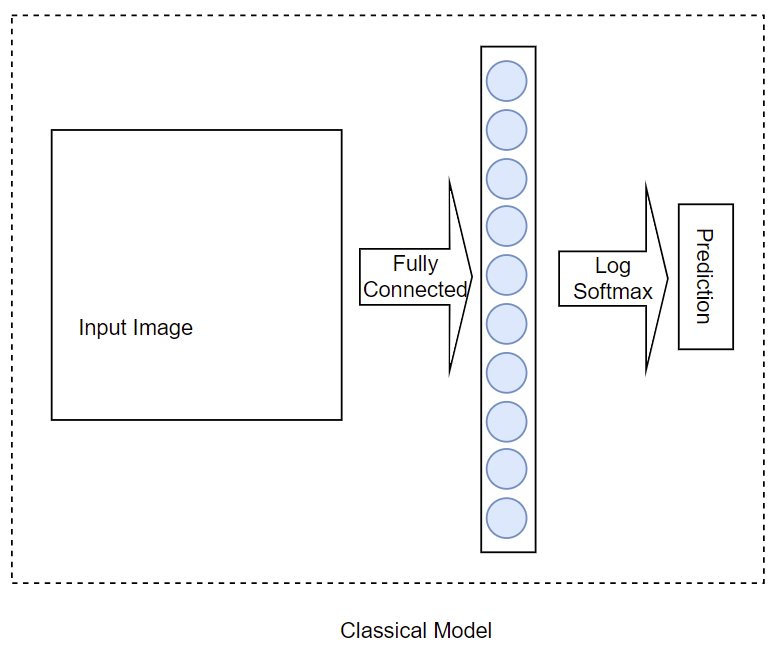

In [ ]:
class HybridModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qf = QuanvolutionFilter()
        self.linear = torch.nn.Linear(4*14*14, 10)

    def forward(self, x, use_qiskit=False):
        with torch.no_grad():
          x = self.qf(x, use_qiskit)
        x = self.linear(x)
        return F.log_softmax(x, -1)

class HybridModel_without_qf(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(28*28, 10)

    def forward(self, x, use_qiskit=False):
        x = x.view(-1, 28*28)
        x = self.linear(x)
        return F.log_softmax(x, -1)

### Load the dataset MNIST
We use MNIST classification dataset(10 digits and 1000 training samples).

The `root` is the folder that stores the dataset. If there’s no MNIST dataset in root, it will automatically download MNIST.
Next, we set the `train_valid_split_ratio`, `n_test_samples`, and `n_train_samples`.

The dataset now contains three splits, 'train', 'valid' and 'test'. For each split, we create a dataloader with a random sampler, `batch_size` is 10, `num_workers` is 8 and `pin_memory` is true.

In [ ]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
dataset = MNIST(
    root='./mnist_data',
    train_valid_split_ratio=[0.9, 0.1],
    n_test_samples=300,
    n_train_samples=500,
)
dataflow = dict()

for split in dataset:
    sampler = torch.utils.data.RandomSampler(dataset[split])
    dataflow[split] = torch.utils.data.DataLoader(
        dataset[split],
        batch_size=10,
        sampler=sampler,
        num_workers=8,
        pin_memory=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

[2022-02-16 04:00:40.771] Only use the front 500 images as TRAIN set.


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



[2022-02-16 04:00:40.868] Only use the front 300 images as TEST set.
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Then we set use_cuda, it depends on whether cuda is available.

Create a device.

Initialize the model, `n_epochs` to 15, Adam optimizer and cosine annealing learning rate scheduler.



In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = HybridModel().to(device)
model_without_qf = HybridModel_without_qf().to(device)
n_epochs = 15
optimizer = optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)

###Train the model.

When training the model, we iterate the dataloader. Get the	`inputs` and `targets` data. Feed `inputs` to the model and get `outputs`. Calculate the negative loss likelihood loss(`F.nll_loss`). Reset all the gradients of parameters in the model to zero. Call `loss.backward()` to perform backpropagation. Call `optimizer.step()` to update all the parameters.

After each epoch, we will valid the model. In validation, we can use qiskit remote because we don’t need to calculate gradients.


In [ ]:
accu_list1 = []
loss_list1 = []
accu_list2 = []
loss_list2 = []

def train(dataflow, model, device, optimizer):
    for feed_dict in dataflow['train']:
        inputs = feed_dict['image'].to(device)
        targets = feed_dict['digit'].to(device)

        outputs = model(inputs)
        loss = F.nll_loss(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"loss: {loss.item()}", end='\r')


def valid_test(dataflow, split, model, device, qiskit=False):
    target_all = []
    output_all = []
    with torch.no_grad():
        for feed_dict in dataflow[split]:
            inputs = feed_dict['image'].to(device)
            targets = feed_dict['digit'].to(device)

            outputs = model(inputs, use_qiskit=qiskit)

            target_all.append(targets)
            output_all.append(outputs)
        target_all = torch.cat(target_all, dim=0)
        output_all = torch.cat(output_all, dim=0)

    _, indices = output_all.topk(1, dim=1)
    masks = indices.eq(target_all.view(-1, 1).expand_as(indices))
    size = target_all.shape[0]
    corrects = masks.sum().item()
    accuracy = corrects / size
    loss = F.nll_loss(output_all, target_all).item()

    print(f"{split} set accuracy: {accuracy}")
    print(f"{split} set loss: {loss}")

    return accuracy, loss

for epoch in range(1, n_epochs + 1):
    # train
    print(f"Epoch {epoch}:")
    train(dataflow, model, device, optimizer)
    print(optimizer.param_groups[0]['lr'])

    # valid
    accu, loss = valid_test(dataflow, 'test', model, device, )
    accu_list1.append(accu)
    loss_list1.append(loss)
    scheduler.step()


Epoch 1:


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.005
test set accuracy: 0.8066666666666666
test set loss: 0.6323180794715881
Epoch 2:
0.004945369001834514
test set accuracy: 0.7766666666666666
test set loss: 0.5900668501853943
Epoch 3:
0.004783863644106502
test set accuracy: 0.8466666666666667
test set loss: 0.48249581456184387
Epoch 4:
0.0045225424859373685
test set accuracy: 0.8133333333333334
test set loss: 0.5225163698196411
Epoch 5:
0.0041728265158971455
test set accuracy: 0.8033333333333333
test set loss: 0.6009621620178223
Epoch 6:
0.00375
test set accuracy: 0.8333333333333334
test set loss: 0.44394049048423767
Epoch 7:
0.0032725424859373687
test set accuracy: 0.84
test set loss: 0.4330306053161621
Epoch 8:
0.002761321158169134
test set accuracy: 0.8366666666666667
test set loss: 0.45171523094177246
Epoch 9:
0.002238678841830867
test set accuracy: 0.8633333333333333
test set loss: 0.4244077205657959
Epoch 10:
0.001727457514062632
test set accuracy: 0.8633333333333333
test set loss: 0.40085339546203613
Epoch 11:
0.00125000000

Train the model without quanvolutional filters.

In [ ]:
optimizer = optim.Adam(model_without_qf.parameters(), lr=5e-3, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)
for epoch in range(1, n_epochs + 1):
    # train
    print(f"Epoch {epoch}:")
    train(dataflow, model_without_qf, device, optimizer)
    print(optimizer.param_groups[0]['lr'])

    # valid
    accu, loss = valid_test(dataflow, 'test', model_without_qf, device)
    accu_list2.append(accu)
    loss_list2.append(loss)

    scheduler.step()

Epoch 1:


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.005
test set accuracy: 0.7733333333333333
test set loss: 0.6043258905410767
Epoch 2:
0.004945369001834514
test set accuracy: 0.8166666666666667
test set loss: 0.5571645498275757
Epoch 3:
0.004783863644106502
test set accuracy: 0.8466666666666667
test set loss: 0.46128183603286743
Epoch 4:
0.0045225424859373685
test set accuracy: 0.8366666666666667
test set loss: 0.5158915519714355
Epoch 5:
0.0041728265158971455
test set accuracy: 0.8666666666666667
test set loss: 0.45338067412376404
Epoch 6:
0.00375
test set accuracy: 0.8466666666666667
test set loss: 0.4563254714012146
Epoch 7:
0.0032725424859373687
test set accuracy: 0.8566666666666667
test set loss: 0.4633018374443054
Epoch 8:
0.002761321158169134
test set accuracy: 0.86
test set loss: 0.46147480607032776
Epoch 9:
0.002238678841830867
test set accuracy: 0.85
test set loss: 0.45319321751594543
Epoch 10:
0.001727457514062632
test set accuracy: 0.84
test set loss: 0.46221110224723816
Epoch 11:
0.0012500000000000007
test set accuracy:

###Compare Quanvolutional Neural Network with classical model.

After training, we can plot the accuracy and loss curve. We can see that model with quanvolutional filter can achieve slightly higher accuracy than model without quanvolution.

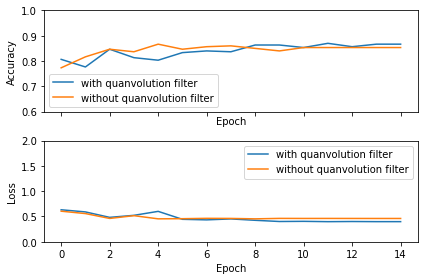

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(accu_list1, label="with quanvolution filter")
ax1.plot(accu_list2, label="without quanvolution filter")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0.6, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(loss_list1, label="with quanvolution filter")
ax2.plot(loss_list2, label="without quanvolution filter")
ax2.set_ylabel("Loss")
ax2.set_ylim([0, 2])
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


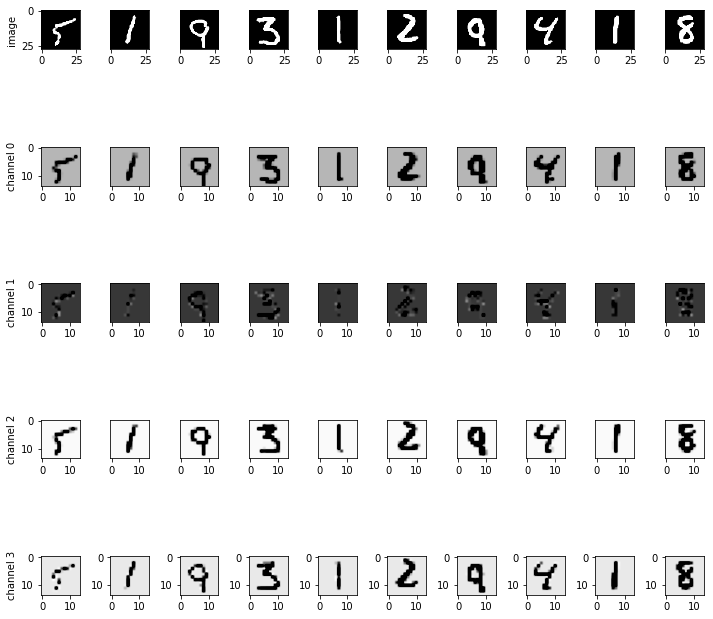

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

n_samples = 10
n_channels = 4
for feed_dict in dataflow['test']:
  inputs = feed_dict['image'].to(device)
  break
sample = inputs[:n_samples]
after_quanv = model.qf(sample).view(n_samples, 14*14, 4).cpu().detach().numpy()

fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("image")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)

    norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

    axes[0, k].imshow(sample[k, 0, :, :].cpu(), norm=norm, cmap="gray")

    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("channel {}".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(after_quanv[k, :, c].reshape(14, 14), norm=norm, cmap="gray")

plt.tight_layout()
plt.show()
